In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install torch torchvision pandas transformers scikit-learn tensorflow numpy seaborn matplotlib textwrap3 sentencepiece

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch
from torchvision import transforms
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image


def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.,!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

def label_to_target(text):
  if text == "not_humanitarian":
    return 0
  elif text == "infrastructure_and_utility_damage":
    return 1
  elif text == "other_relevant_information":
    return 2
  elif text == "rescue_volunteering_or_donation_effort":
    return 3
  elif text == "affected_individuals":
    return 4

df_train = pd.read_csv("./gdrive/MyDrive/Models/train.tsv", sep='\t')
df_train = df_train[['image', 'tweet_text', 'label_text']]
df_train = df_train.sample(frac=1, random_state = 24).reset_index(drop=True)
df_train['tweet_text'] = df_train['tweet_text'].apply(clean_text)
df_train['label_text'] = df_train['label_text'].apply(label_to_target)

df_val = pd.read_csv("./gdrive/MyDrive/Models/val.tsv", sep='\t')
df_val = df_val[['image', 'tweet_text', 'label_text']]
df_val = df_val.sample(frac=1, random_state = 24).reset_index(drop=True)
df_val['tweet_text'] = df_val['tweet_text'].apply(clean_text)
df_val['label_text'] = df_val['label_text'].apply(label_to_target)

df_test = pd.read_csv("./gdrive/MyDrive/Models/test.tsv", sep='\t')
df_test = df_test[['image', 'tweet_text', 'label_text']]
df_test = df_test.sample(frac=1, random_state = 24).reset_index(drop=True)
df_test['tweet_text'] = df_test['tweet_text'].apply(clean_text)
df_test['label_text'] = df_test['label_text'].apply(label_to_target)


In [5]:
data_dir = "./gdrive/MyDrive/"
class DisasterTweetDataset(Dataset):

  def __init__(self, tweets, targets, paths, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.paths = paths
    self.transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]
    path = str(self.paths[item])
    img = Image.open(data_dir+self.paths[item]).convert('RGB')
    img = self.transform(img)  

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'tweet_image': img
    }

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = DisasterTweetDataset(
    tweets=df.tweet_text.to_numpy(),
    targets=df.label_text.to_numpy(),
    paths=df.image.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )


class TweetClassifier(nn.Module):

  def __init__(self):
    super(TweetClassifier, self).__init__()
    self.xlnet = XLNetModel.from_pretrained("xlnet-base-cased")
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
    self.resnet = torchvision.models.resnet18(pretrained=True)
    for param in self.resnet.parameters():
      param.requires_grad = False
    
    self.bn = nn.BatchNorm1d(self.xlnet.config.hidden_size*MAX_LEN + 1000)

    self.linear1 = nn.Linear(self.xlnet.config.hidden_size*MAX_LEN + 1000, 1000)
    self.relu1    = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.4)

    self.linear2 = nn.Linear(1000, 500)
    self.relu2    = nn.ReLU()
    self.dropout2 = nn.Dropout(p=0.2)

    self.linear3 = nn.Linear(500, 250)
    self.relu3    = nn.ReLU()
    self.dropout3 = nn.Dropout(p=0.1)

    self.linear4 = nn.Linear(250, 125)
    self.relu4    = nn.ReLU()
    self.dropout4 = nn.Dropout(p=0.02)

    self.linear5 = nn.Linear(125, 5)
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self, input_ids, attention_mask, tweet_img):
    text_output = self.xlnet(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )

    text_output = text_output[0]
    text_output = torch.reshape(text_output, (-1, MAX_LEN*self.xlnet.config.hidden_size))

    image_output = self.resnet(tweet_img)
    merged_output = torch.cat((text_output, image_output), dim=1)
    bn_output = self.bn(merged_output)

    linear1_output = self.linear1(bn_output)
    relu1_output = self.relu1(linear1_output)
    dropout1_output = self.dropout1(relu1_output)

    linear2_output = self.linear2(dropout1_output)
    relu2_output = self.relu2(linear2_output)
    dropout2_output = self.dropout2(relu2_output)

    linear3_output = self.linear3(dropout2_output)
    relu3_output = self.relu3(linear3_output)
    dropout3_output = self.dropout3(relu3_output)

    linear4_output = self.linear4(dropout3_output)
    relu4_output = self.relu4(linear4_output)
    dropout4_output = self.dropout4(relu4_output)

    linear5_output = self.linear5(dropout4_output)


    probas = self.softmax(linear5_output)
    return probas


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    tweet_imgs = d["tweet_image"].to(device)
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].long()
    targets = targets.to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      tweet_img = tweet_imgs
    )


    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(torch.max(outputs, dim=1).indices == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      tweet_imgs = d["tweet_image"].to(device)
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].long()
      targets = targets.to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        tweet_img = tweet_imgs
      )

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(torch.max(outputs, dim=1).indices == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [6]:
BATCH_SIZE = 512
MAX_LEN = 150

PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


model = TweetClassifier()
model = model.to(device)

EPOCHS = 70

optimizer = AdamW(model.parameters(), lr=1e-2)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Epoch 1/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 21.551883469025295 accuracy 0.4268690825987594
Val   loss 1.4180526733398438 accuracy 0.39378757515030055

Epoch 2/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.017608384291331 accuracy 0.6118184786157362
Val   loss 0.9727209508419037 accuracy 0.625250501002004

Epoch 3/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.8691708594560623 accuracy 0.677930133855697
Val   loss 1.1655213832855225 accuracy 0.5661322645290581

Epoch 4/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.7855197141567866 accuracy 0.7060071825008162
Val   loss 0.8750589191913605 accuracy 0.6803607214428857

Epoch 5/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.7325494339068731 accuracy 0.7370225269343781
Val   loss 0.7741808593273163 accuracy 0.7314629258517034

Epoch 6/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.7020055651664734 accuracy 0.7491021873979758
Val   loss 0.767487496137619 accuracy 0.6933867735470941

Epoch 7/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.6486158867677053 accuracy 0.7704864511916422
Val   loss 0.7613328993320465 accuracy 0.7374749498997996

Epoch 8/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.630839983622233 accuracy 0.7832190662748939
Val   loss 0.6917639672756195 accuracy 0.7204408817635269

Epoch 9/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.6196202586094538 accuracy 0.7908912830558276
Val   loss 0.6644608378410339 accuracy 0.7575150300601202

Epoch 10/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.5941303571065267 accuracy 0.7966046359777995
Val   loss 0.6980237066745758 accuracy 0.7565130260521041

Epoch 11/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.5700908253590266 accuracy 0.8031341821743389
Val   loss 0.672845870256424 accuracy 0.7595190380761523

Epoch 12/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.5895549108584722 accuracy 0.7998694090760692
Val   loss 0.7488413155078888 accuracy 0.7414829659318637

Epoch 13/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.5878963793317477 accuracy 0.8005223636957232
Val   loss 0.6684592664241791 accuracy 0.7695390781563125

Epoch 14/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.5172934010624886 accuracy 0.8197845249755141
Val   loss 0.6857520341873169 accuracy 0.7725450901803607

Epoch 15/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.536335734029611 accuracy 0.8194580476656872
Val   loss 0.7233397364616394 accuracy 0.7615230460921844

Epoch 16/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.5154489229122797 accuracy 0.8199477636304277
Val   loss 0.6984838843345642 accuracy 0.7755511022044087

Epoch 17/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.5042222738265991 accuracy 0.8276199804113614
Val   loss 0.6964529752731323 accuracy 0.7865731462925851

Epoch 18/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.5049057801564535 accuracy 0.8307215148547176
Val   loss 0.7701282501220703 accuracy 0.7725450901803607

Epoch 19/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.477946013212204 accuracy 0.8321906627489389
Val   loss 0.6458852887153625 accuracy 0.7845691382765531

Epoch 20/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.5001148929198583 accuracy 0.8277832190662748
Val   loss 0.6271138191223145 accuracy 0.7955911823647294

Epoch 21/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.47600535303354263 accuracy 0.8421482206986615
Val   loss 0.7002688348293304 accuracy 0.7895791583166332

Epoch 22/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.46755149712165195 accuracy 0.8447600391772772
Val   loss 0.6833544075489044 accuracy 0.7815631262525049

Epoch 23/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.4488702267408371 accuracy 0.8455762324518445
Val   loss 0.7303542494773865 accuracy 0.783567134268537

Epoch 24/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.4512825558582942 accuracy 0.8454129937969311
Val   loss 0.6252974569797516 accuracy 0.7925851703406813

Epoch 25/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.4594723880290985 accuracy 0.8405158341495266
Val   loss 0.6712229549884796 accuracy 0.7775551102204408

Epoch 26/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.4629196524620056 accuracy 0.8426379366634019
Val   loss 0.7081781327724457 accuracy 0.8066132264529058

Epoch 27/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.44759701192379 accuracy 0.846718903036239
Val   loss 0.6800163686275482 accuracy 0.8056112224448897

Epoch 28/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.4280763690670331 accuracy 0.8576558929154423
Val   loss 0.6437831223011017 accuracy 0.7945891783567134

Epoch 29/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.42198316752910614 accuracy 0.85145282402873


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.4162631829579671 accuracy 0.8625530525628469
Val   loss 0.6666645407676697 accuracy 0.7955911823647294

Epoch 31/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.4280366450548172 accuracy 0.8480248122755468
Val   loss 0.809023916721344 accuracy 0.7805611222444889

Epoch 32/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.43627028663953143 accuracy 0.8490042442050277
Val   loss 0.7686569094657898 accuracy 0.785571142284569

Epoch 33/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.4253321836392085 accuracy 0.8610839046686255
Val   loss 0.6375093460083008 accuracy 0.7945891783567134

Epoch 34/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3891970341404279 accuracy 0.8676134508651648
Val   loss 0.6519068777561188 accuracy 0.8076152304609218

Epoch 35/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.37574126571416855 accuracy 0.870388507998694
Val   loss 0.7146957218647003 accuracy 0.812625250501002

Epoch 36/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.38961397111415863 accuracy 0.866960496245511
Val   loss 0.7464669048786163 accuracy 0.8106212424849699

Epoch 37/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3985596646865209 accuracy 0.860920666013712
Val   loss 0.7124713361263275 accuracy 0.7895791583166332

Epoch 38/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.36350558201471966 accuracy 0.8733268037871368
Val   loss 0.7174020409584045 accuracy 0.8006012024048096

Epoch 39/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.34983881562948227 accuracy 0.8762650995755795
Val   loss 0.8474795520305634 accuracy 0.7875751503006011

Epoch 40/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3780964861313502 accuracy 0.8676134508651648
Val   loss 0.7827459573745728 accuracy 0.8036072144288576

Epoch 41/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3807651648918788 accuracy 0.8788769180541952
Val   loss 0.7177786231040955 accuracy 0.8096192384769538

Epoch 42/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.35818877071142197 accuracy 0.881162259222984
Val   loss 0.809315413236618 accuracy 0.7985971943887775

Epoch 43/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.36974500864744186 accuracy 0.8765915768854065
Val   loss 0.6891208589076996 accuracy 0.7985971943887775

Epoch 44/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.33043884485960007 accuracy 0.8862226575253019
Val   loss 0.6700053513050079 accuracy 0.8016032064128256

Epoch 45/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.323943759004275 accuracy 0.8901403852432256
Val   loss 0.7491597831249237 accuracy 0.813627254509018

Epoch 46/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.32282355676094693 accuracy 0.8867123734900424
Val   loss 0.751847505569458 accuracy 0.8006012024048096

Epoch 47/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3196876496076584 accuracy 0.890956578517793
Val   loss 0.8167333006858826 accuracy 0.8066132264529058

Epoch 48/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.30379785348971683 accuracy 0.8924257264120143
Val   loss 0.7480177879333496 accuracy 0.812625250501002

Epoch 49/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.30712612221638363 accuracy 0.8938948743062357
Val   loss 0.6922239363193512 accuracy 0.8066132264529058

Epoch 50/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2819897457957268 accuracy 0.900750897812602
Val   loss 0.8565674722194672 accuracy 0.8036072144288576

Epoch 51/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.29175323247909546 accuracy 0.9000979431929481
Val   loss 0.720057874917984 accuracy 0.8056112224448897

Epoch 52/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.31318243344624835 accuracy 0.8932419196865817
Val   loss 0.7178564071655273 accuracy 0.8016032064128256

Epoch 53/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2930869037906329 accuracy 0.8920992491021874
Val   loss 0.71998330950737 accuracy 0.8046092184368737

Epoch 54/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.28210676833987236 accuracy 0.8997714658831211
Val   loss 0.7617705464363098 accuracy 0.7945891783567134

Epoch 55/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2801639127234618 accuracy 0.8997714658831211
Val   loss 0.7400650084018707 accuracy 0.8076152304609218

Epoch 56/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2827470041811466 accuracy 0.90581129611492
Val   loss 0.7112817764282227 accuracy 0.8066132264529058

Epoch 57/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.26702215522527695 accuracy 0.9079333986287953
Val   loss 0.7720407545566559 accuracy 0.7975951903807614

Epoch 58/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2662176949282487 accuracy 0.9100555011426705
Val   loss 0.7128517627716064 accuracy 0.8006012024048096

Epoch 59/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.263430184374253 accuracy 0.915932092719556
Val   loss 0.730347067117691 accuracy 0.81563126252505

Epoch 60/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2577272007862727 accuracy 0.9067907280444009
Val   loss 0.7540527880191803 accuracy 0.8116232464929859

Epoch 61/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2567705685893695 accuracy 0.910218739797584
Val   loss 0.7079009115695953 accuracy 0.8096192384769538

Epoch 62/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.26308051993449527 accuracy 0.9089128305582762
Val   loss 0.6956637501716614 accuracy 0.8116232464929859

Epoch 63/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23513328159848848 accuracy 0.9216454456415278
Val   loss 0.7784313559532166 accuracy 0.8096192384769538

Epoch 64/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.24593995635708174 accuracy 0.9146261834802482
Val   loss 0.7809551358222961 accuracy 0.8106212424849699

Epoch 65/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2338273674249649 accuracy 0.9170747633039503
Val   loss 0.745591402053833 accuracy 0.812625250501002

Epoch 66/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23012768601377806 accuracy 0.9174012406137774
Val   loss 0.7390166521072388 accuracy 0.8116232464929859

Epoch 67/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2364634871482849 accuracy 0.9214822069866144
Val   loss 0.7437699735164642 accuracy 0.8086172344689379

Epoch 68/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.22734871009985605 accuracy 0.9211557296767875
Val   loss 0.755601167678833 accuracy 0.8116232464929859

Epoch 69/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23158777132630348 accuracy 0.9195233431276526
Val   loss 0.7662545442581177 accuracy 0.8106212424849699

Epoch 70/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.24576334406932196 accuracy 0.9167482859941234
Val   loss 0.7624479234218597 accuracy 0.8086172344689379



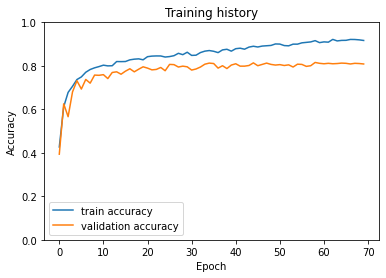

In [7]:
history = defaultdict(list)
start_epoch = 0
best_accuracy = -1

# checkpoint = torch.load("./gdrive/MyDrive/Models/XLNetResNet/checkpoint-50.t7")
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']
# best_accuracy = checkpoint['best_accuracy']

# print(start_epoch)
# print(best_accuracy)


for epoch in range(EPOCHS):

  print(f'Epoch {start_epoch + epoch + 1}/{start_epoch + EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    state = {
            'best_accuracy': val_acc,
            'epoch': start_epoch+epoch+1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }
    savepath= "./gdrive/MyDrive/Models/XLNetResNet/checkpoint.t7"
    torch.save(state,savepath)
    best_accuracy = val_acc

state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/Models/XLNetResNet/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/Models/XLNetResNet/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

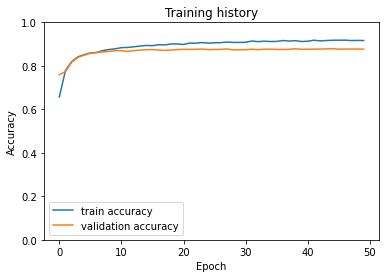

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [8]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      tweet_imgs = d["tweet_image"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].long()
      targets = targets.to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        tweet_img = tweet_imgs
      )
      preds = torch.max(outputs, dim=1).indices


      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=['not_humanitarian', 'infrastructure_and_utility_damage', 'other_relevant_information', 'rescue_volunteering_or_donation_effort', 'affected_individuals'], digits = 4))

                                        precision    recall  f1-score   support

                      not_humanitarian     0.8474    0.8591    0.8532       504
     infrastructure_and_utility_damage     0.7674    0.8148    0.7904        81
            other_relevant_information     0.8182    0.8043    0.8112       235
rescue_volunteering_or_donation_effort     0.6880    0.6825    0.6853       126
                  affected_individuals     0.0000    0.0000    0.0000         9

                              accuracy                         0.8105       955
                             macro avg     0.6242    0.6321    0.6280       955
                          weighted avg     0.8044    0.8105    0.8073       955

